In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os

In [2]:
names = ['ssp126',
         "ssp370",
        'ssp585',
         'hist-aer',
         'hist-GHG',
         'historical',
        ]

In [3]:
outputs={}
inputs={}
#load in our data from train_vals for the inputs and outputs
for name in names:
    if "hist" in name:
        inputs[f"{name}"] = xr.open_dataset(f"../train_val/inputs_{name}.nc")
        outputs_temp = xr.open_dataset(f"../train_val/outputs_{name}.nc").mean(dim='member')
    else:
        inputs[f"{name}"] = xr.open_mfdataset(['../train_val/inputs_historical.nc', 
                                    f"../train_val/inputs_{name}.nc"]).compute()
        
        outputs_temp = xr.concat([xr.open_dataset("../train_val/outputs_historical.nc").mean(dim='member'),
                               xr.open_dataset(f"../train_val/outputs_{name}.nc").mean(dim='member')],
                               dim='time').compute()
        
    outputs_temp = outputs_temp.assign({"pr": outputs_temp.pr * 86400, "pr90": outputs_temp.pr90 * 86400})
    outputs_temp = outputs_temp.rename({'lon':'longitude', 'lat': 'latitude'}).transpose('time','latitude', 'longitude')
    outputs_temp = outputs_temp.drop_vars('quantile')
    outputs[f"{name}"] = outputs_temp

In [4]:
len_historical_data = len(outputs['historical'].time)

In [5]:
del outputs['historical']
del inputs['historical']

In [6]:
mean_std_dict={}
input_vars = ['CO2', 'CH4', 'SO2', 'BC']
#takes the mean and standard deviation of all the input variables
for var in input_vars:
    once_historical = []
    
    for key in inputs.keys():
        #counts historical data only once, for ssp126
        if "ssp" in key and key!="ssp126":
            data=inputs[key][var].sel(time=slice(len_historical_data, None)).data
            once_historical.append(data)
        else:
            data=inputs[key][var].data
            once_historical.append(data)
    once_historical_array = np.concatenate(once_historical)
        
    mean_std_dict[var] = (once_historical_array.mean(), once_historical_array.std())
    print(var)
    print("Mean: ", mean_std_dict[var][0], "Standard Deviation: ", mean_std_dict[var][1])

CO2
Mean:  1074.172303244536 Standard Deviation:  1755.690699230666
CH4
Mean:  0.1927369743762821 Standard Deviation:  0.18457590641432994
SO2
Mean:  2.5623359997066674e-12 Standard Deviation:  2.25011456678326e-11
BC
Mean:  1.4947905009818114e-13 Standard Deviation:  1.031334255483836e-12


In [7]:
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def unnormalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return data * std + mean

In [8]:
X_train_norm = [] 
#Normalize the input variables
for key, data in inputs.items(): 
    for var in input_vars: 
        var_dims = data[var].dims
        data=data.assign({var: (var_dims, normalize(data[var].data, var, mean_std_dict))}) 
    X_train_norm.append(data)

In [9]:
#temporal window to track trends over time
slider = 10 

In [10]:
#reshapes data for prediction with sliders
def training_input(X_train, skip_historical=False):
    X_train_np = X_train.to_array().transpose('time', 'latitude', 'longitude', 'variable').data

    time_length = X_train_np.shape[0]
    #If we skip historical, then start at the length of historical onwards rather than from 1850
    if skip_historical:
         X_train_mod = np.array([X_train_np[i:i+slider] for i in range(len_historical_data-slider+1, time_length-slider+1)])
    else:
        X_train_mod = np.array([X_train_np[i:i+slider] for i in range(0, time_length-slider+1)])

    return X_train_mod

def training_output(Y_train, var, skip_historical=False):
    Y_train_np = Y_train[var].data

    time_length = Y_train_np.shape[0]
    #If we skip historical, then start at the length of historical onwards rather than from 1850
    if skip_historical:
         Y_train_mod = np.array([[Y_train_np[i+slider-1]] for i in range(len_historical_data-slider+1, time_length-slider+1)])
    else:
        Y_train_mod = np.array([[Y_train_np[i+slider-1]] for i in range(0, time_length-slider+1)])

    return Y_train_mod

In [11]:
predict_var='tas'
Y_train=list(outputs.values())
#Concatenates the training inputs and the outputs, making sure to only count historical once
X_train_all = np.concatenate([training_input(X_train_norm[i], 
                                                 skip_historical=(i<2), 
                                                 ) for i in range(len(outputs))], axis = 0)
Y_train_all = np.concatenate([training_output(Y_train[i], 
                                                  predict_var, 
                                                  skip_historical=(i<2), 
                                                 ) for i in range(len(outputs))], axis=0)
print(X_train_all.shape, Y_train_all.shape)

(726, 10, 96, 144, 4) (726, 1, 96, 144)


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Input, Reshape, AveragePooling2D, MaxPooling2D, Conv2DTranspose, TimeDistributed, LSTM, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import random 
seed = 6 
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [13]:
keras.backend.clear_session()
cnn_model = None

In [14]:
cnn_model = Sequential()
cnn_model.add(Input(shape=(slider, 96, 144, 4)))
cnn_model.add(TimeDistributed(Conv2D(20, (3, 3), padding='same', activation='relu')))
cnn_model.add(TimeDistributed(AveragePooling2D(2)))
cnn_model.add(TimeDistributed(GlobalAveragePooling2D()))
cnn_model.add(LSTM(25, activation='relu'))
cnn_model.add(Dense(1*96*144))
cnn_model.add(Activation('linear'))
cnn_model.add(Reshape((1, 96, 144)))

In [15]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 10, 96, 144, 20)     │             740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 10, 48, 72, 20)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 10, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 25)                  │           4,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 13824)               │         359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 13824)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 96, 144)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 364,764 (1.39 MB)

 Trainable params: 364,764 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
X_train_all.shape, Y_train_all.shape

((726, 10, 96, 144, 4), (726, 1, 96, 144))

In [17]:
cnn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mse']) 

In [18]:
#Constructrs data generator for tensorflow 2.18, comment out if using Tensorflow 2.10 and use below
hist = cnn_model.fit(X_train_all,
                     Y_train_all,
                     batch_size=16,
                     epochs=30,
                     verbose=1,
                    )

#hist = cnn_model.fit(X_train_all,
#                    Y_train_all,
#                    use_multiprocessing=True, 
#                    #workers=5,
#                    batch_size=16,
#                    epochs=30,
#                    verbose=1)
#

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 452ms/step - loss: 2.7271 - mse: 2.7271
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 451ms/step - loss: 0.4963 - mse: 0.4963
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - loss: 0.3967 - mse: 0.3967
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - loss: 0.3884 - mse: 0.3884
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - loss: 0.3823 - mse: 0.3823
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - loss: 0.3765 - mse: 0.3765
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - loss: 0.3702 - mse: 0.3702
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - loss: 0.3524 - mse: 0.3524
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - loss: 0.3285 - mse: 0.3285
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - loss: 0.3198 - mse: 0.3198
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - loss: 0.3158 - mse: 0.3158
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - loss: 0.3130 - mse: 0.3130
Epoch 13/30
4

In [19]:
X_test = xr.open_dataset(f"../test/inputs_ssp245.nc")
Y_test = xr.open_dataset(f"../test/outputs_ssp245.nc").mean(dim='member')

In [20]:
X_test_norm = xr.Dataset()
#Normalizes Test Data
for var in input_vars:
    dims = X_test[var].dims
    X_test_norm = X_test_norm.assign({var: (dims, normalize(X_test[var].data, var, mean_std_dict))} )

In [21]:
X_test_all  = training_input(X_test_norm)

In [22]:
#Predicts off test data
m_pred = cnn_model.predict(X_test_all)
m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])
m_pred = xr.DataArray(m_pred, dims=['time', 'lat', 'lon'], coords=[X_test.time.data[slider-1:], X_test.latitude.data, X_test.longitude.data])
m_pred = m_pred.transpose('time', 'lat', 'lon').sel(time=slice(2015, 2101)).to_dataset(name=predict_var)
m_pred

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


<xarray.Dataset> Size: 4MB
Dimensions:  (time: 77, lat: 96, lon: 144)
Coordinates:
  * time     (time) int64 616B 2024 2025 2026 2027 2028 ... 2097 2098 2099 2100
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    tas      (time, lat, lon) float32 4MB 1.077 1.056 1.098 ... 5.497 5.476

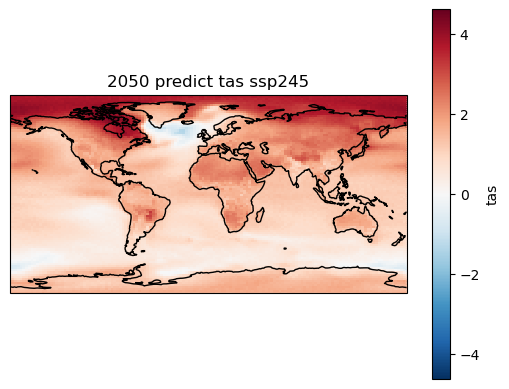

In [24]:
#Visualizes the model's predicted tas for 2050
alpha = m_pred['tas'].sel(time=2050).plot(transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': ccrs.PlateCarree()})
plt.gca().set_title('2050 predict tas ssp245')
plt.gca().coastlines()

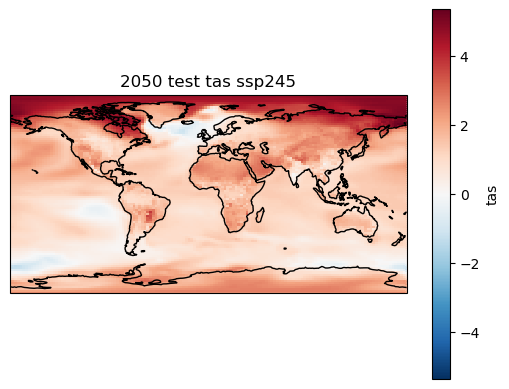

In [25]:
#Visualizes the actual tas for 2050
beta = Y_test['tas'].sel(time=2050).plot(transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': ccrs.PlateCarree()})
plt.gca().set_title('2050 test tas ssp245')
plt.gca().coastlines()

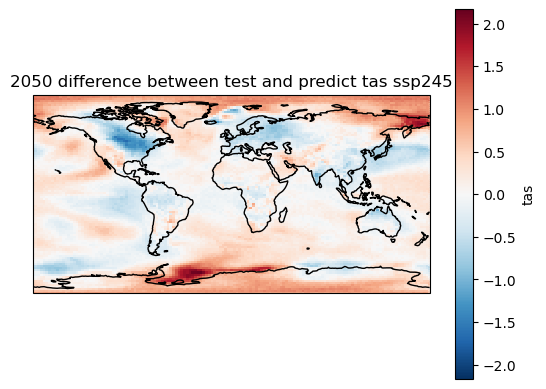

In [26]:
#Visualizes the difference between actual and predicted tas for 2050
(Y_test['tas']-m_pred['tas']).sel(time=2050).plot(transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': ccrs.PlateCarree()})
plt.gca().set_title('2050 difference between test and predict tas ssp245')
plt.gca().coastlines()

In [27]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

In [28]:
print(f"RMSE at 2050: {get_rmse(Y_test[predict_var][35], m_pred[predict_var].sel(time=2050))}")
print(f"RMSE at 2100: {get_rmse(Y_test[predict_var][85], m_pred[predict_var].sel(time=2100))}")
print(f"RMSE 2045-2055: {get_rmse(Y_test[predict_var][30:41], m_pred[predict_var].sel(time=slice(2045, 2055)))}")
print(f"RMSE 2090-2100: {get_rmse(Y_test[predict_var][75:], m_pred[predict_var].sel(time=slice(2090, 2100)))}")
print(f"RMSE 2050-2100: {get_rmse(Y_test[predict_var][35:], m_pred[predict_var].sel(time=slice(2050, 2100)))}")

print(f"RMSE average last 20y: {get_rmse(Y_test[predict_var][-20:].mean(dim='time'),  m_pred[predict_var][-20:].mean(dim='time'))}")

RMSE at 2050: 0.36620983361418086
RMSE at 2100: 0.3862124353265415
RMSE 2045-2055: 0.39816862816306087
RMSE 2090-2100: 0.4313775029239601
RMSE 2050-2100: 0.4331768989470518
RMSE average last 20y: 0.29905970325923464


In [ ]:
os.makedirs('../outputs', exist_ok=True)
datapath="../outputs"

In [ ]:
m_pred.to_netcdf(datapath + 'cnn_outputs_ssp245_predict_{}.nc'.format(predict_var), 'w')

In [31]:
m_pred.close()

### Repeat the process above in one cell for all Prediction Variables rather than just 'tas' and saves the output in results

In [32]:
vars_to_predict = [ 'diurnal_temperature_range', 'pr', 'pr90']

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - loss: 0.0763 - mse: 0.0763
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - loss: 0.0729 - mse: 0.0729
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 451ms/step - loss: 0.0472 - mse: 0.0472
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - loss: 0.0415 - mse: 0.0415
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 455ms/step - loss: 0.0393 - mse: 0.0393
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - loss: 0.0387 - mse: 0.0387
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - loss: 0.0383 - mse: 0.0383
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 454ms/step - loss: 0.0379 - mse: 0.0379
Epoch 9/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - loss: 0.0376 - mse: 0.0376
Epoch 10/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - loss: 0.0373 - mse: 0.0373
Epoch 11/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - loss: 0.0370 - mse: 0.0370
Epoch 12/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - loss: 0.0367 - mse: 0.0367
Epoch 13/30
4

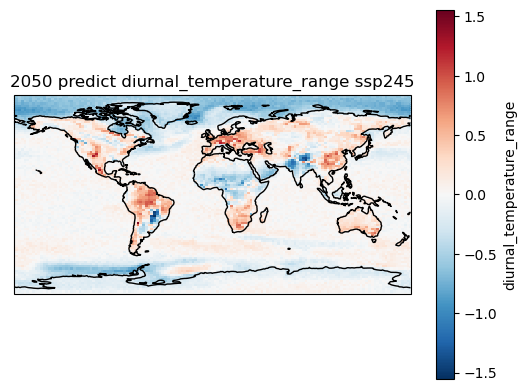

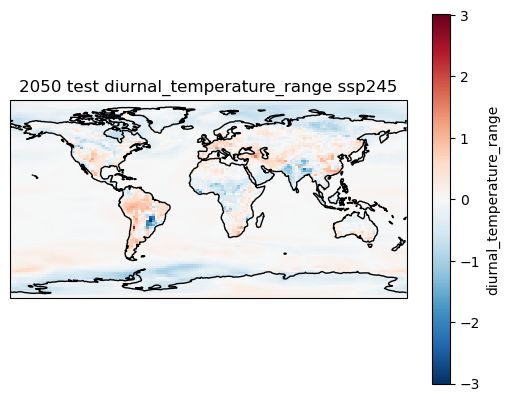

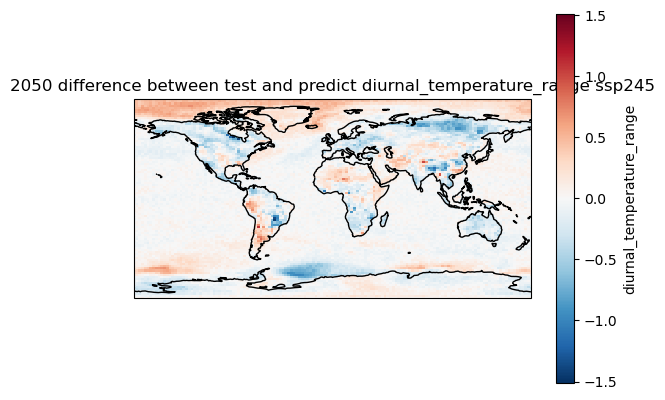

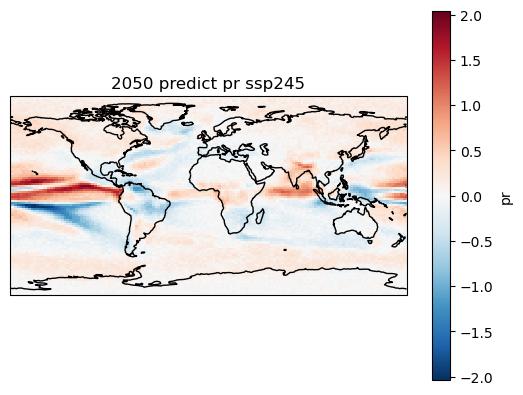

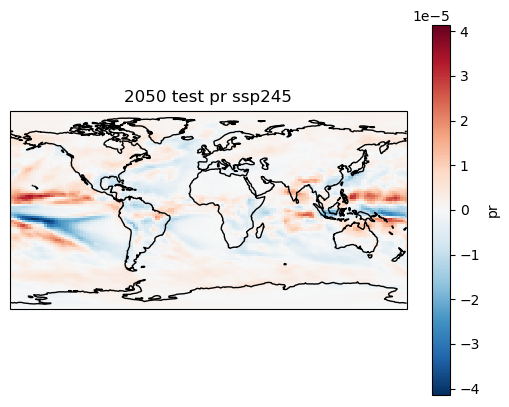

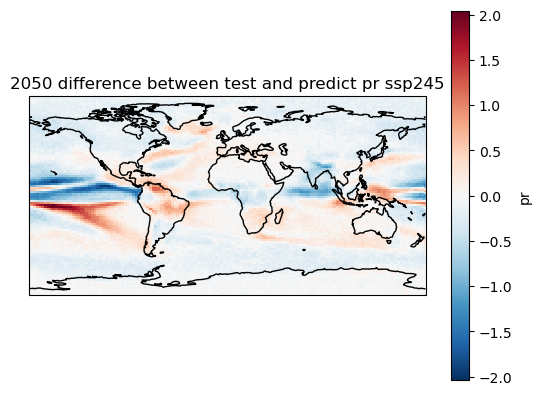

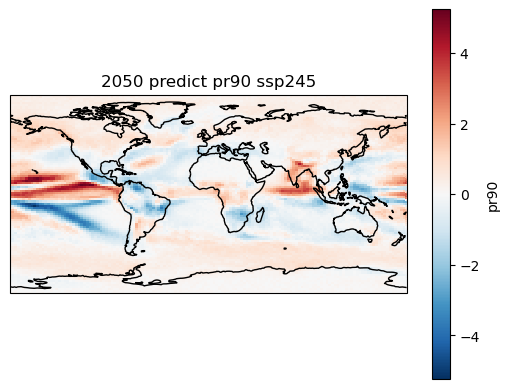

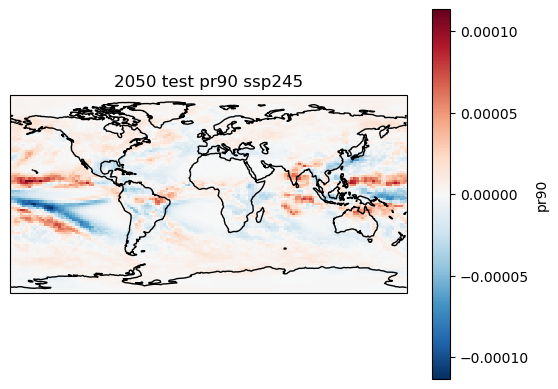

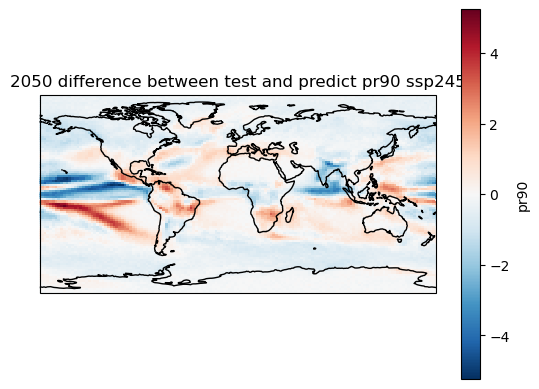

In [ ]:
for predict_var in vars_to_predict:
    #Takes the xtrains
    Y_train=list(outputs.values())
    X_train_all = np.concatenate([training_input(X_train_norm[i], 
                                                 skip_historical=(i<2), 
                                                 ) for i in range(len(outputs))], axis = 0)
    Y_train_all = np.concatenate([training_output(Y_train[i], 
                                                  predict_var, 
                                                  skip_historical=(i<2), 
                                                 ) for i in range(len(outputs))], axis=0)
            
    keras.backend.clear_session()
    cnn_model = None

    #Establishes the model
    cnn_model = Sequential()
    cnn_model.add(Input(shape=(slider, 96, 144, 4)))
    cnn_model.add(TimeDistributed(Conv2D(20, (3, 3), padding='same', activation='relu')))
    cnn_model.add(TimeDistributed(AveragePooling2D(2)))
    cnn_model.add(TimeDistributed(GlobalAveragePooling2D()))
    cnn_model.add(LSTM(25, activation='relu'))
    cnn_model.add(Dense(1*96*144))
    cnn_model.add(Activation('linear'))
    cnn_model.add(Reshape((1, 96, 144)))

    cnn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mse']) 
    #Constructrs data generator for tensorflow 2.18, comment out if using Tensorflow 2.10 and use below
    hist = cnn_model.fit(X_train_all,
                     Y_train_all,
                     batch_size=16,
                     epochs=30,
                    )

    #hist = cnn_model.fit(X_train_all,
    #                    Y_train_all,
    #                    use_multiprocessing=True, 
    #                    #workers=5,
    #                    batch_size=16,
    #                    epochs=30,
    #                    callbacks=[early_stopping],
    #                     )

    #Pred
    m_pred = cnn_model.predict(X_test_all)
    m_pred = m_pred.reshape(m_pred.shape[0], m_pred.shape[2], m_pred.shape[3])
    m_pred = xr.DataArray(m_pred, dims=['time', 'lat', 'lon'], coords=[X_test.time.data[slider-1:], X_test.latitude.data, X_test.longitude.data])
    m_pred = m_pred.transpose('time', 'lat', 'lon').sel(time=slice(2015, 2101)).to_dataset(name=predict_var)
    m_pred

    print(f"RMSE at 2050: {get_rmse(Y_test[predict_var][35], m_pred[predict_var].sel(time=2050))}")
    print(f"RMSE at 2100: {get_rmse(Y_test[predict_var][85], m_pred[predict_var].sel(time=2100))}")
    print(f"RMSE 2045-2055: {get_rmse(Y_test[predict_var][30:41], m_pred[predict_var].sel(time=slice(2045, 2055)))}")
    print(f"RMSE 2090-2100: {get_rmse(Y_test[predict_var][75:], m_pred[predict_var].sel(time=slice(2090, 2100)))}")
    print(f"RMSE 2050-2100: {get_rmse(Y_test[predict_var][35:], m_pred[predict_var].sel(time=slice(2050, 2100)))}")

    print(f"RMSE average last 20y: {get_rmse(Y_test[predict_var][-20:].mean(dim='time'),  m_pred[predict_var][-20:].mean(dim='time'))}")

    plt.figure()
    m_pred[predict_var].sel(time=2050).plot(transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': ccrs.PlateCarree()})
    plt.gca().set_title(f'2050 predict {predict_var} ssp245')
    plt.gca().coastlines()

    plt.figure()
    beta = Y_test[predict_var].sel(time=2050).plot(transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': ccrs.PlateCarree()})
    plt.gca().set_title(f'2050 test {predict_var} ssp245')
    plt.gca().coastlines()

    plt.figure()
    (Y_test[predict_var]-m_pred[predict_var]).sel(time=2050).plot(transform=ccrs.PlateCarree(), 
                                                 subplot_kws={'projection': ccrs.PlateCarree()})
    plt.gca().set_title(f'2050 difference between test and predict {predict_var} ssp245')
    plt.gca().coastlines()

    if predict_var=="pr90" or predict_var=="pr":
        m_pred = m_pred.assign({predict_var: m_pred[predict_var] / 86400})

    # Save test predictions as .nc 
    if predict_var == 'diurnal_temperature_range':
        m_pred.to_netcdf(datapath + 'cnn_outputs_ssp245_predict_dtr.nc', 'w')
    else:
        m_pred.to_netcdf(datapath + 'cnn_outputs_ssp245_predict_{}.nc'.format(predict_var), 'w')
    m_pred.close()